# **Birds Recognition**

## **Import and Install**

In [1]:
# !pip install -U albumentations

In [2]:
# import libraries
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras

from pathlib import Path
import shutil

import  cv2
from    cv2 import imread
from scipy.signal import  convolve2d
from PIL import Image
import torchvision
from   torchvision import datasets, models, transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator

from pandas.core.frame import DataFrame

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

print('Tensorflow version= ',tf.__version__)

2022-07-15 23:18:45.462824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-15 23:18:45.462867: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version=  2.9.1


## **Printing Functions**

In [3]:
# Printing images from directory
def print_images_from_dir(dir, img_num = 15, rows = 3, cols = 5):
    dir = dir + '/'
    dirnames = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 4*rows))
    
    for j,i in enumerate(dirnames[:img_num]):
        ax = axes[j//cols, j%cols]
        file = dir + i + '/'+ os.listdir(dir+i)[0]
        image = mpimg.imread(file)
        ax.imshow(image)
        ax.set_title('Label: {}'.format(i))
    plt.tight_layout()
    plt.show()

## **Data**

In [4]:
# PATH = '../../../d/Images/nabirds/'
PATH = '../../../d/Images/nabirds/'

PATH_TRAIN = PATH + 'Train/'
PATH_TEST = PATH + 'Test/'
PATH_VAL = PATH + 'Validation/'

IMGS_PATH = '../../../d/Images/nabirds/images/'

In [5]:
# path_imgs = 'D:/Images/nabirds/images/'
# birds_DB = ['House_Sparrow', 'American_Pipit', 'Gadwall', 'European_Goldfinch','Horned_Grebe']

birds_DB = ['0857','0527','1005', '0525', '0315', '0796']
birds_names_DB = ['American Pipit', 'Eurasian Collared-Dove', 'House Sparrow', 'European Starling', 'Gadwall', 'Rock Pigeon']
# 440 American Pipit
# 857 American Pipit
# 527 Eurasian Collared-Dove
# 1005 European Starling (Juvenile)
# 525 Rock Pigeon
# 315 Gadwall (Breeding male)
# 445 House Sparrow 796

# TODO : Change Numbers to names
def create_listdir(imgs): # Fixes the '._' bug
  dir_lst = []
  for dir in os.listdir(imgs):
    if dir[:2] == '._':
      dir_lst.append(dir[2:])
    else:
      dir_lst.append(dir)
  return dir_lst

In [6]:
bird_dict = { 
    'American Pipit': ['0440','0857'],
    'Eurasian Collared-Dove' : ['0105', '0527'] , 
    'House Sparrow': ['0445', '0796', '1003'],
    'European Starling' : ['0439', '0748', '0856', '1005'],
    'Gadwall' : ['0315','0614', '0037'], 
    'Rock Pigeon' : ['0525', '0045'],
}
print(bird_dict.keys())
# def rename_folders(birds_DB, bird_dict):
#   for num in birds_DB:
#     b_name = ''
#     for key in bird_dict.keys():
#       if num in bird_dict.get(key): 
#         print(f'{num} is {key}')
#         b_name = key
#         brds = 'nabirds'
#         os.rename(f'D:\Images\{brds}\images\{num}', f'D:\Images\{brds}\images\{b_name}')

dict_keys(['American Pipit', 'Eurasian Collared-Dove', 'House Sparrow', 'European Starling', 'Gadwall', 'Rock Pigeon'])


In [7]:
# rename_folders(birds_DB, bird_dict)


In [8]:
# def create_folders(b_name):
#   paths = [PATH_TRAIN, PATH_TEST, PATH_VAL]
#   n_paths = []
#   for pth in paths:
#     pt = pth + b_name + '/'
#     n_paths.append(pt)
#     os.mkdir(pt)
#   return n_paths
# size = (224,224)

# def name_folders(bird):
#   paths = [PATH_TRAIN, PATH_TEST, PATH_VAL]
#   n_paths = []
#   for pth in paths:
#     pt = pth + bird + '/'
#     n_paths.append(pt)
#   return n_paths

# def create_data(path, birds_list=birds_names_DB):
#   my_imgs = []
#   count_imgs = 0 # Counts all images
#   for dir in create_listdir(path):
#     dir_count=0 # Counts every dir's images
#     if dir in birds_list:
#         current_path = path + '/' + dir
#         print(f'Reads from: {dir}')
#         # cpth = create_listdir(current_path)
#         # n_pths = create_folders(dir)
#         n_pths = name_folders(dir)
#         # print(os.listdir(current_path))
#         # for image in create_listdir(current_path): 
#         for image in os.listdir(current_path): 
#           c_path = current_path + '/' + image # current image path
#           c_image = cv2.imread(c_path)#, cv2.COLOR_BGR2RGB)
#           c_image = cv2.resize(c_image, size)
#           my_imgs.append([c_path, dir, '']) # tupple with (img dir, target)
#           dir_count += 1 

#         train_imgs = int(dir_count * 0.7)
#         test_imgs = int(dir_count * 0.2)
#         # print(f'num of train: {train_imgs} \nNum of test: {test_imgs}\nNum of val: \nDIR_COUNT: {dir_count}')
        
#         for i, img in enumerate(os.listdir(current_path)):
#           c_path = current_path + '/' + img # current image path
#           if i <= train_imgs:
#             my_imgs[count_imgs + i][2] = 'train'
#             shutil.copy2(c_path, n_pths[0])
#           elif i <= train_imgs + test_imgs:
#             my_imgs[count_imgs + i][2] = 'test'
#             shutil.copy2(c_path,  n_pths[1])
#           else: 
#             my_imgs[count_imgs + i][2] = 'valid'
#             shutil.copy2(c_path,  n_pths[2])
#         count_imgs += dir_count
        
#   return my_imgs, count_imgs


# def data_to_csv(path, birds_list=birds_names_DB):
#   my_imgs, count_imgs = create_data(path, birds_list)
#   df = pd.DataFrame(data=my_imgs, columns=['path','name','dataset'])
#   df.to_csv()
#   return df

# my_df = data_to_csv(path_imgs) ## Create csv of file


#### Create Augmentations


In [9]:
# Helping matrixes
sobelX = np.asarray(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]), dtype=np.float32) * 1/16
sobelY = np.asarray(([-1,-2,-1], [0, 0, 0], [1, 2, 1]), dtype=np.float32) * 1/16
laplacian = np.array(([0, -1, 0], [-1, 5, -1], [0, -1, 0]), dtype='int') * 0.25 

mats = [sobelX, sobelY, laplacian]

# Calculates padding
def calculate_padding_single_dim(dim_in, dim_out, kernel_size):
    return  int(np.ceil((dim_out - dim_in + kernel_size) /2 ) -1)

In [10]:
## Sharping
def sharp_img(img, kernel=laplacian):
  for i in range(img.shape[-1]):
    sharpened_img = convolve2d(img[:, :, i], kernel) # img convolation with matrix
  return np.abs(sharpened_img) # values are positive

## Rotate
def rotate(img: np.ndarray, angle: int):
  h, w = img.shape[0], img.shape[1]
  res_img = np.zeros(img.shape) # New image creation
  # Angle's calculations
  angle = np.deg2rad(angle)
  cos_a = np.cos(angle)
  sin_a = np.sin(angle)
  # Image's center
  midY = round(((h + 1) / 2) - 1)
  midX = round(((w + 1) / 2) - 1)
  # Result's center
  yCenter = round((midY * cos_a) - (midX * sin_a))
  xCenter = round((midY * sin_a) + (midX * cos_a))

  for y in range(h):
    for x in range(w):
      nX = round((y * sin_a) + (x * cos_a)) - xCenter + midX
      nY = round((y * cos_a) - (x * sin_a)) - yCenter + midY
      if (w > nX and (nX > 0)) and (h > nY and (nY > 0)):
        res_img[nY ,nX] = img[y ,x]
  
  return res_img.astype(np.uint8)

## Horizontal Flip
def horizontal_flip(img):
  f_img = img[:, ::-1]
  return f_img


angles = [-20, 20]

In [11]:
import random
from PIL import Image


def img_augmentation(img_name, path_dir):
    added_imgs = []
    for i in range(6):
        img = np.array(Image.open(f'{path_dir}/{img_name}'))
        rnd = random.randint(0, 11)
        if (rnd // 2 == 0):
            n_img = sharp_img(img,kernel=mats[random.randint(0,len(mats)-1)])
        else:
            n_img = img
        if (rnd // 3 == 0):
            n_img = rotate(n_img, angle=random.randint(angles[0], angles[1]))
        if (rnd // 5 == 0):
            n_img = horizontal_flip(n_img)
        added_imgs.append(n_img)

    return added_imgs

def dir_augments(path_dir):
    added_imgs = []
    for img in os.listdir(path_dir):
        added_imgs = added_imgs + img_augmentation(img,path_dir)
    count = 0
    for img in added_imgs:
        im = Image.fromarray(img)
        im.save(f'{path_dir}/aug_{count}.jpg')
        count += 1     

def augmentations():
    for pth in [PATH_TRAIN, PATH_TEST, PATH_VAL]:
        print('doit')
        for bird_dir in os.listdir(pth):
            print(f'path = {bird_dir}')
            dir_augments(f'{pth}/{bird_dir}/')

In [12]:
def create_folders(b_name):
  paths = [PATH_TRAIN, PATH_TEST, PATH_VAL]
  n_paths = []
  for pth in paths:
    pt = pth + b_name + '/'
    n_paths.append(pt)
    if not os.path.exists(pt):
      os.mkdir(pt)
  return n_paths
size = (224,224)

def name_folders(bird):
  paths = [PATH_TRAIN, PATH_TEST, PATH_VAL]
  n_paths = []
  for pth in paths:
    pt = pth + bird + '/'
    n_paths.append(pt)
  return n_paths

def create_data(path, birds_list=birds_names_DB):
  my_imgs = []
  count_imgs = 0 # Counts all images
  for dir in create_listdir(path):
    dir_count=0 # Counts every dir's images
    if dir in birds_list:
        current_path = path + '/' + dir
        print(f'Reads from: {dir}')
        # cpth = create_listdir(current_path)
        n_pths = create_folders(dir)
        # n_pths = name_folders(dir)
        # print(os.listdir(current_path))
        # for image in create_listdir(current_path): 
        for image in os.listdir(current_path): 
          c_path = current_path + '/' + image # current image path
          c_image = cv2.imread(c_path)#, cv2.COLOR_BGR2RGB)
          c_image = cv2.resize(c_image, size)
          my_imgs.append([c_path, dir, '']) # tupple with (img dir, target)
          dir_count += 1 

        train_imgs = int(dir_count * 0.7)
        test_imgs = int(dir_count * 0.2)
        # print(f'num of train: {train_imgs} \nNum of test: {test_imgs}\nNum of val: \nDIR_COUNT: {dir_count}')

        for i, img in enumerate(os.listdir(current_path)):
          c_path = current_path + '/' + img # current image path
          if i <= train_imgs:
            my_imgs[count_imgs + i][2] = 'train'
            shutil.copy2(c_path, n_pths[0])
          elif i <= train_imgs + test_imgs:
            my_imgs[count_imgs + i][2] = 'test'
            shutil.copy2(c_path,  n_pths[1])
          else: 
            my_imgs[count_imgs + i][2] = 'valid'
            shutil.copy2(c_path,  n_pths[2])
        count_imgs += dir_count
        
  return my_imgs, count_imgs

def data_to_csv(path, birds_list=birds_names_DB):
  my_imgs, count_imgs = create_data(path, birds_list)
  df = pd.DataFrame(data=my_imgs, columns=['path','name','dataset'])
  df.to_csv()
  return df

my_df = data_to_csv(IMGS_PATH) ## Create csv of file


Reads from: American Pipit
Reads from: Eurasian Collared-Dove
Reads from: European Starling
Reads from: Gadwall
Reads from: House Sparrow
Reads from: Rock Pigeon


In [13]:
# augmentations()

In [14]:
# }train_path = []
test_path = []
train_df = my_df.query("dataset == 'train'")
test_df = my_df.query("dataset == 'test'")

### **Choosing our birds**

## **Dataset**

In [15]:
df_train = my_df.query("dataset == 'train' ")
del df_train['dataset']

df_test = my_df.query("dataset == 'test' ")
del df_test['dataset']

df_valid = my_df.query("dataset == 'valid' ")
del df_valid['dataset']


In [16]:
# def create_directory(dir_name, df, birds_list=birds_DB):
#   drive.mount(dir_name)
#   for bird in birds_list:
#     pth = dir_name + '/' + bird + '/'
#     drive.mount(pth)
#     # TODO: Upload files
    

In [17]:
# Data augmentation for training using ImageDataGenerator 

from keras.preprocessing.image import ImageDataGenerator

# Training data
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
                                                    PATH_TRAIN,
                                                    target_size=(224,224),
                                                    batch_size= 30,
                                                    class_mode='categorical')

# Test data
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
                                                    PATH_TEST,
                                                    target_size=(224,224),
                                                    batch_size= 30,
                                                    class_mode='categorical')

# Validation data
valid_datagen = ImageDataGenerator(rescale=1/255)
valid_generator = valid_datagen.flow_from_directory(
                                                    PATH_VAL,
                                                    target_size=(224,224),
                                                    batch_size= 30,
                                                    class_mode='categorical')


Found 3192 images belonging to 6 classes.
Found 889 images belonging to 6 classes.
Found 448 images belonging to 6 classes.


## **Models**

### Densenet model definition, training, evaluation

In [18]:
# densenet201_raw_model = tf.keras.applications.densenet.DenseNet201(include_top=False,
#                                                                 weights='imagenet',
#                                                                 input_shape=(224,224,3), # input size of the images(fixed)
#                                                                 pooling='max')

# # To not train these weights with our training images
# for layers in densenet201_raw_model.layers:
#     layers.trainable=False

# # append Dense layers to clssify it for number of classes for the given problem
# num_of_classes = len(birds_DB)
# densenet201_model_output = densenet201_raw_model.layers[-1].output
# appended_layer = tf.keras.layers.Flatten()(densenet201_model_output)
# appended_layer = tf.keras.layers.Dense(num_of_classes, activation='softmax')(appended_layer)


# # final model
# densenet201_final_model = tf.keras.Model(densenet201_raw_model.input, appended_layer)
# print(densenet201_final_model.summary())
# densenet201_final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# history = densenet201_final_model.fit(
#                                     train_generator,
#                                     epochs=150,
#                                     validation_data=valid_generator)

# try:
#     # vgg_model.save_model('./weights/vgg')
#     tf.keras.models.save_model(densenet201_final_model,filepath='./weights/denseNet')
# except Exception as e:
#     print(f'Failed to save weights')
#     print(e)

In [20]:
# densenet201_final_model.evaluate(test_generator)


In [21]:
# def plot_loss_curves_densenet(history):
    
#     '''
#       returns seperate loss curves for training and validation metrics
#     '''
#     train_loss=history.history['loss']
#     val_loss=history.history['val_loss']

#     train_accuracy=history.history['accuracy']
#     val_accuracy=history.history['val_accuracy']

#     epochs=range(1,len(history.history['loss'])+1)
#     plt.figure(figsize=(20,7))
#   # plot loss data
#     plt.subplot(1,2,1)
#     plt.plot(epochs,train_loss,label="training_loss")
#     plt.plot(epochs,val_loss,label="validation_loss")
#     plt.title("Loss curves")
#     plt.xlabel('epochs')
#     plt.ylabel('loss')
#     plt.legend()
#   # plt.show()

#   # plot accuracy data
#     plt.subplot(1,2,2)
#     plt.plot(epochs,train_accuracy,label="training_acc")
#     plt.plot(epochs,val_accuracy,label="validation_acc")
#     plt.title("Accuracy curves")
#     plt.xlabel('epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

# plot_loss_curves_densenet(history)

### VGG16

In [22]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224 ,224 , 3))
#eff_model.summary()
vgg_model.trainable = False

layer0 = keras.layers.Flatten(name='flatten')(vgg_model.output)
layer1 = keras.layers.Dense(224, activation='relu',name='fc1')(layer0)
layer2 = keras.layers.Dense(224, activation='relu',name='fc2')(layer1)
out_layer = keras.layers.Dense(6, activation='softmax')(layer2)
vgg_model = keras.Model(vgg_model.input, out_layer)
vgg_model.summary()

2022-07-15 23:19:14.432817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-15 23:19:14.434406: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mitrlior/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-07-15 23:19:14.434445: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mitrlior/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-07-15 23:19:14.434487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror:

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [24]:
opt = keras.optimizers.Adam(learning_rate=0.001)
vgg_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'], )
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
            #   ,
            #   ModelCheckpoint(filepath="./weights/vgg.{epoch:02d}-{acc:.2f}.h5", monitor='val_acc', save_best_only=False, mode='max')
            ]

history_vgg = vgg_model.fit(
    train_generator, 
    epochs=50,
    verbose=1,
    validation_data = valid_generator,
    callbacks=callbacks)

Epoch 1/50
107/107 [==============================] - 316s 3s/step - loss: 0.9848 - accuracy: 0.6629 - val_loss: 1.1693 - val_accuracy: 0.5871
Epoch 2/50
107/107 [==============================] - 314s 3s/step - loss: 0.3270 - accuracy: 0.8850 - val_loss: 1.4630 - val_accuracy: 0.5603
Epoch 3/50
107/107 [==============================] - 311s 3s/step - loss: 0.2770 - accuracy: 0.8994 - val_loss: 1.7909 - val_accuracy: 0.4955
Epoch 4/50
107/107 [==============================] - 309s 3s/step - loss: 0.2372 - accuracy: 0.9076 - val_loss: 1.5675 - val_accuracy: 0.5647


In [25]:
try:
    # vgg_model.save_model('./weights/vgg')
    tf.keras.models.save_model(vgg_model,filepath='./weights/vgg')
except Exception as e:
    print(f'Failed to save weights')
    print(e)

INFO:tensorflow:Assets written to: ./weights/vgg/assets


INFO:tensorflow:Assets written to: ./weights/vgg/assets


In [26]:
vgg_loaded_model = tf.keras.models.load_model('./weights/vgg')

In [27]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
vgg_model.trainable = True
vgg_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
            # ,
            # ModelCheckpoint(filepath='Fullmodel.{epoch:02d}-{acc:.2f}.h5', monitor='val_acc', save_best_only=False, mode='max')
            ]

history_vgg = vgg_model.fit(
    train_generator, 
    epochs=50,
    verbose=1,
    validation_data = valid_generator,
    callbacks=callbacks)

try:
    tf.keras.models.save_model(vgg_model,filepath='./weights/vgg2')
except Exception as e:
    print(f'Failed to save weights')
    print(e)

Epoch 1/50
107/107 [==============================] - 1219s 11s/step - loss: 0.3276 - accuracy: 0.8813 - val_loss: 0.9861 - val_accuracy: 0.7121
Epoch 2/50
107/107 [==============================] - 1206s 11s/step - loss: 0.2350 - accuracy: 0.9088 - val_loss: 1.8934 - val_accuracy: 0.6049
Epoch 3/50
107/107 [==============================] - 1195s 11s/step - loss: 0.1659 - accuracy: 0.9398 - val_loss: 1.1993 - val_accuracy: 0.6875
Epoch 4/50
107/107 [==============================] - 1193s 11s/step - loss: 0.1291 - accuracy: 0.9565 - val_loss: 1.0578 - val_accuracy: 0.7299
Epoch 5/50
107/107 [==============================] - 1195s 11s/step - loss: 0.1067 - accuracy: 0.9630 - val_loss: 1.2136 - val_accuracy: 0.7299
Epoch 6/50
107/107 [==============================] - 1161s 11s/step - loss: 0.0699 - accuracy: 0.9756 - val_loss: 1.2341 - val_accuracy: 0.7545
Epoch 7/50
107/107 [==============================] - 1181s 11s/step - loss: 0.0631 - accuracy: 0.9778 - val_loss: 1.4392 - val_ac

INFO:tensorflow:Assets written to: ./weights/vgg2/assets


INFO:tensorflow:Assets written to: ./weights/vgg2/assets


In [28]:
opt = keras.optimizers.Adam(learning_rate=0.00001)
vgg_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
            # ,
            # ModelCheckpoint(filepath='Fullmodel.{epoch:02d}-{acc:.2f}.h5', monitor='val_acc', save_best_only=False, mode='max')]
            ]

history_vgg = vgg_model.fit(
    train_generator, 
    epochs=50,
    verbose=1,
    validation_data = valid_generator,
    callbacks=callbacks)

try:
    tf.keras.models.save_model(vgg_model,filepath='./weights/vgg3')
except Exception as e:
    print(f'Failed to save weights')
    print(e)

Epoch 1/50
107/107 [==============================] - 1012s 9s/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 1.5552 - val_accuracy: 0.7991
Epoch 2/50
107/107 [==============================] - 1009s 9s/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 2.0885 - val_accuracy: 0.7679
Epoch 3/50
107/107 [==============================] - 1025s 10s/step - loss: 8.1467e-04 - accuracy: 1.0000 - val_loss: 1.4769 - val_accuracy: 0.8058
Epoch 4/50
107/107 [==============================] - 1004s 9s/step - loss: 9.7375e-05 - accuracy: 1.0000 - val_loss: 1.7744 - val_accuracy: 0.7946
Epoch 5/50
107/107 [==============================] - 1006s 9s/step - loss: 6.3233e-05 - accuracy: 1.0000 - val_loss: 1.6760 - val_accuracy: 0.8125
Epoch 6/50
107/107 [==============================] - 1004s 9s/step - loss: 2.4826e-05 - accuracy: 1.0000 - val_loss: 1.7044 - val_accuracy: 0.8080
Epoch 7/50
107/107 [==============================] - 1019s 10s/step - loss: 1.8902e-05 - accuracy: 1.0000 - val_loss: 

INFO:tensorflow:Assets written to: ./weights/vgg3/assets


INFO:tensorflow:Assets written to: ./weights/vgg3/assets


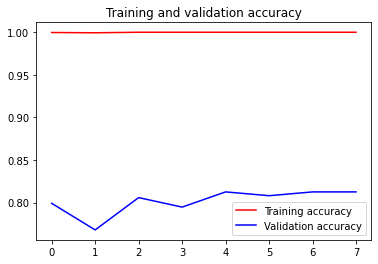

<Figure size 432x288 with 0 Axes>

In [29]:

acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [30]:
test = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test.flow_from_directory(
        PATH_TEST,
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical')

Found 889 images belonging to 6 classes.


In [31]:
vgg_model.evaluate(test_generator,use_multiprocessing=True,workers=10)

2022-07-16 06:26:10.448392: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 822083584 exceeds 10% of free system memory.
2022-07-16 06:26:10.723291: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 822083584 exceeds 10% of free system memory.


 1/14 [=>............................] - ETA: 1:26 - loss: 148.7773 - accuracy: 0.7812

2022-07-16 06:26:15.428684: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 822083584 exceeds 10% of free system memory.
2022-07-16 06:26:15.674111: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 822083584 exceeds 10% of free system memory.


 2/14 [===>..........................] - ETA: 51s - loss: 143.4861 - accuracy: 0.7891 

2022-07-16 06:26:19.695227: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 822083584 exceeds 10% of free system memory.


14/14 [==============================] - 61s 4s/step - loss: 151.6234 - accuracy: 0.7593


[151.6234130859375, 0.7592800855636597]

### MobileNet V3

In [32]:
base_model = keras.applications.MobileNetV3Small(input_shape=(224, 224, 3),
                                            classes=len(birds_names_DB),
                                            include_top=False,
                                            weights='imagenet')

# Freeze convolutional base
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [33]:
data_augmentation = keras.models.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.2)
])
num_classes = len(birds_names_DB)# 7

inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
mobile_model = keras.Model(inputs, outputs)
mobile_model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
mobile_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3462      
                                                                 
Total params: 942,582
Trainable params: 3,462
Non-trainable

In [34]:
early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

history_mobileNet = mobile_model.fit(train_datagen, 
                            validation_data=valid_datagen,
                            epochs=150,
                            callbacks=[early_stop])

try:
    mobile_model.save_model('./weights/mobile')
except Exception as e:
    print(f'Failed to save weights')
    print(e)

ValueError: Failed to find data adapter that can handle input: <class 'keras.preprocessing.image.ImageDataGenerator'>, <class 'NoneType'>

In [ ]:
initial_epochs = len(history_mobileNet.history['accuracy'])

acc = history_mobileNet.history['accuracy']
val_acc = history_mobileNet.history['val_accuracy']

loss = history_mobileNet.history['loss']
val_loss = history_mobileNet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

NameError: name 'history_mobileNet' is not defined

### EfficientNetB0


In [ ]:
IMAGE_SIZE=(224,224)

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TRAIN,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)
class_names=train_data.class_names
num_classes=len(class_names)
val_data=tf.keras.preprocessing.image_dataset_from_directory(
    PATH_VAL,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    
)
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TEST,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False
)

train_data_pf=train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data_pf=val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_pf=test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3192 files belonging to 6 classes.
Found 448 files belonging to 6 classes.
Found 889 files belonging to 6 classes.


In [ ]:
from keras import layers
from keras import layers,mixed_precision

#### EfficientB0

In [ ]:
#1 Define Data Augmentation Layer
data_augmentation=keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2,fill_mode='nearest'),
    # layers.Rescaling(scale=1.0/255)
],name='Data_Augmentation_Layer')

In [ ]:
#2 Create the model
# import efficientnet.keras as efn 

mixed_precision.set_global_policy('float32')

inputs=layers.Input(shape=(224,224,3), dtype='float32',name='input_layer')

base_model = keras.applications.EfficientNetB0(weights='imagenet') 

# base_model.trainable=False

x=data_augmentation(inputs)
x=base_model(x,training=False)

# x=layers.GlobalAveragePooling2D(name='Global_Average_Pool_2D')(x)
num_classes=len(train_data.class_names)
outputs=layers.Dense(num_classes,activation='softmax',dtype=tf.float32,name="Output_layer")(x)

model=keras.Model(inputs,outputs,name="model")

In [ ]:
#3 Compile the model
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

#4 model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation_Layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, 1000)             5330571   
                                                                 
 Output_layer (Dense)        (None, 6)                 6006      
                                                                 
Total params: 5,336,577
Trainable params: 5,294,554
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
#5 Fit the model
history_of_model=model.fit(
                                    train_generator,
                                    epochs=100,
                                    validation_data=valid_generator)

Epoch 1/100
25/25 [==============================] - 393s 15s/step - loss: 1.7804 - accuracy: 0.1842 - val_loss: 1.7787 - val_accuracy: 0.1875
Epoch 2/100
25/25 [==============================] - 373s 15s/step - loss: 1.7801 - accuracy: 0.1842 - val_loss: 1.7783 - val_accuracy: 0.1875
Epoch 3/100
25/25 [==============================] - 369s 15s/step - loss: 1.7798 - accuracy: 0.1842 - val_loss: 1.7781 - val_accuracy: 0.1875
Epoch 4/100
25/25 [==============================] - 366s 15s/step - loss: 1.7796 - accuracy: 0.1842 - val_loss: 1.7779 - val_accuracy: 0.1875
Epoch 5/100
25/25 [==============================] - ETA: 0s - loss: 1.7796 - accuracy: 0.1842 

In [ ]:
#6 model_0 result
model_0_result=model.evaluate(test_data_pf)
model_0_result

28/28 [==============================] - 24s 857ms/step - loss: 1.7806 - accuracy: 0.1811


[1.7805765867233276, 0.18110236525535583]

In [ ]:
def plot_loss_curves(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

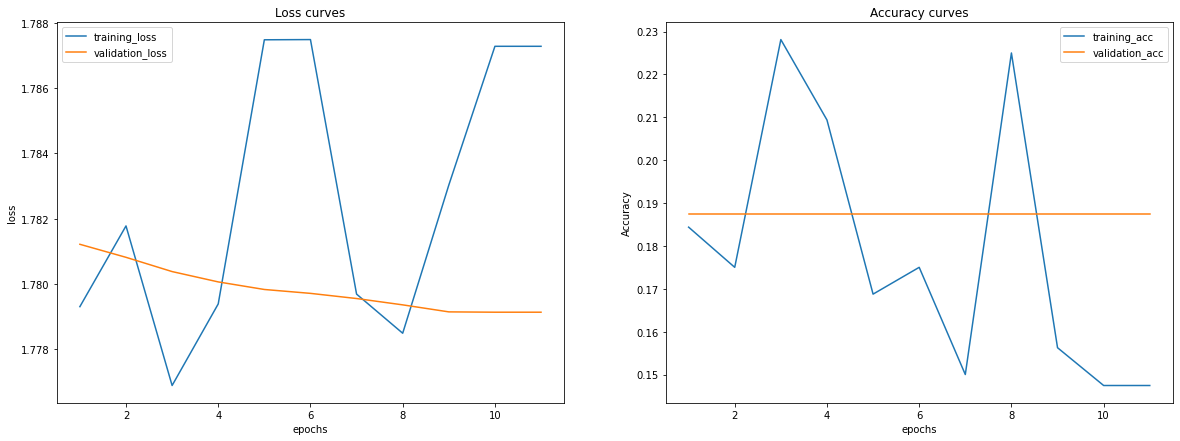

In [ ]:
plot_loss_curves(history_of_model)